In [1]:
import pandas as pd
import numpy as np
import random

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [2]:
df_train = pd.read_csv('data/data_train.csv')
df_test = pd.read_csv('data/data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())

data.head()

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Stacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

Accuracy: 67.02%

F1 Score: 67.02

COnfusion Matrix:
 [[469  32  44  28 120]
 [ 73 420  55  16 115]
 [ 56  18 475  68  90]
 [ 61  20  76 385  96]
 [ 68  20  48  15 525]]


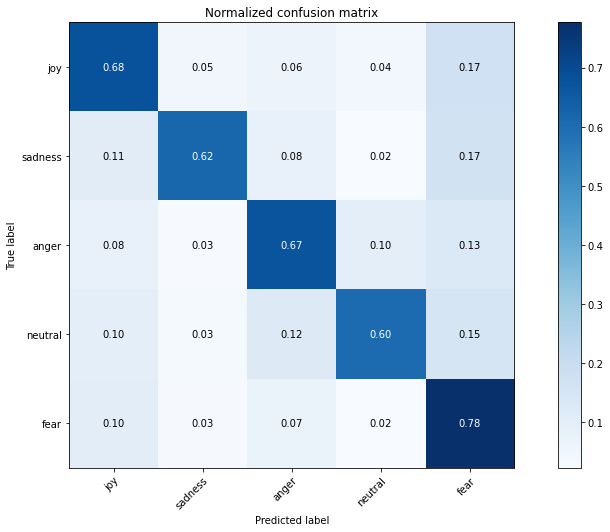

In [7]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Random Forrest

Accuracy: 63.81%

F1 Score: 63.81

COnfusion Matrix:
 [[404  85  58  84  62]
 [ 80 434  50  70  45]
 [ 55  54 433 120  45]
 [ 41  22  34 510  31]
 [ 85  69  72  66 384]]


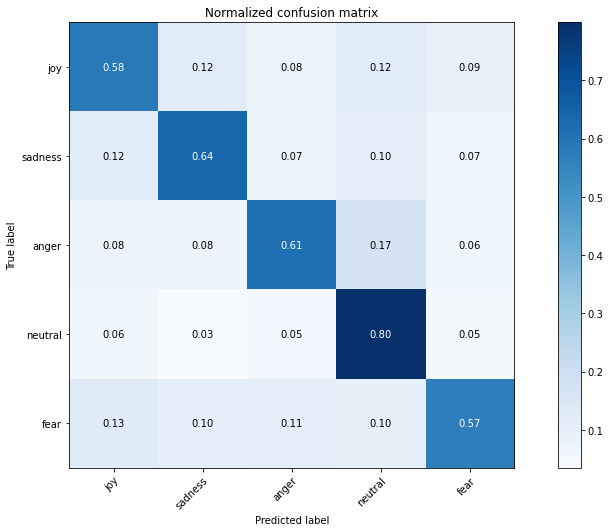

In [8]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Logistic Regression

Accuracy: 69.35%

F1 Score: 69.35

COnfusion Matrix:
 [[456  67  44  68  58]
 [ 65 483  42  50  39]
 [ 56  34 476 101  40]
 [ 41  23  42 498  34]
 [ 82  60  51  43 440]]


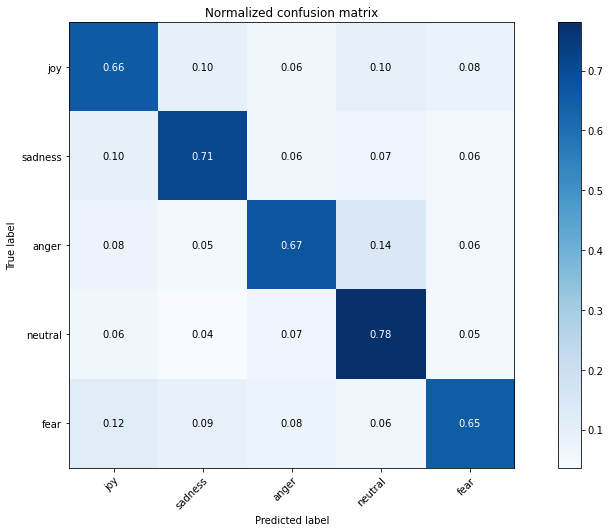

In [9]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Linear Support Vector

Accuracy: 72.71%

F1 Score: 72.71

COnfusion Matrix:
 [[490  49  41  58  55]
 [ 53 508  34  40  44]
 [ 50  33 498  91  35]
 [ 34  23  38 505  38]
 [ 72  43  53  42 466]]


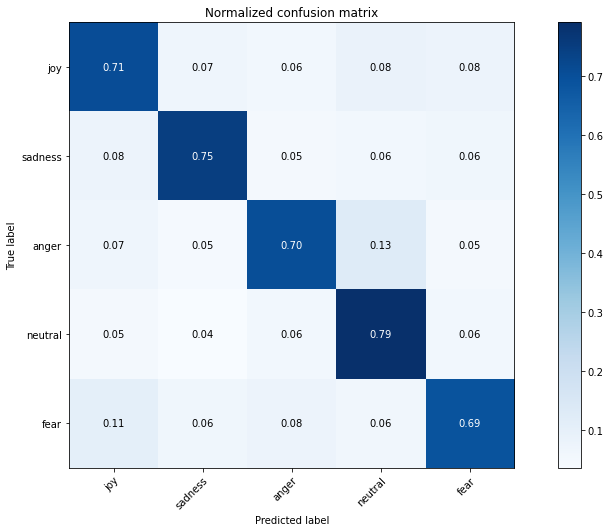

In [10]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [11]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [12]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [13]:
model = pickle.load(open(filename, 'rb'))

message = 'Trying to make sense of the horrors of World War II Death relates the story of Liesel a young German girl whose book stealing and story telling talents help sustain her family and the Jewish man they are hiding as well as their neighbors ' 
model.predict([message])

array(['fear'], dtype=object)

In [14]:
df=pd.read_csv('book_data.csv',nrows=1000)
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.780680e+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [15]:
df['book_desc']=df['book_desc'].str.replace(r'[\W_]+',' ')

In [16]:
df=df[df['book_desc'].notnull()]

In [17]:
df=df[-(df['book_desc']==' ')]

In [18]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous Losing means cert...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.780680e+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [19]:
import langdetect as ld
def is_en(txt):
    try:
        return ld.detect(txt)=='en'
    except: 
        return False
    
df=df[df['book_desc'].apply(is_en)]

In [20]:
df.reset_index(drop=True)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous Losing means cert...,NaN,Hardcover,9.780440e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780440e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780060e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Stephenie Meyer,About three things I was absolutely positive F...,NaN,Paperback,9.780320e+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...
4,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.780380e+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...
...,...,...,...,...,...,...,...,...,...,...,...,...
974,Terry Pratchett,Arch swindler Moist Van Lipwig never believed ...,NaN,Mass Market Paperback,9.780060e+12,394 pages,4.37,89341,2540,Going Postal,Fantasy|Fiction|Humor,https://images.gr-assets.com/books/1388236899l...
975,Frank Miller|Klaus Janson|Lynn Varley,This masterpiece of modern comics storytelling...,NaN,Hardcover,9.781560e+12,197 pages,4.25,149561,3081,Batman: The Dark Knight Returns,Sequential Art|Comics|Sequential Art|Graphic N...,https://images.gr-assets.com/books/1327892039l...
976,Murasaki Shikibu|Royall Tyler,See an alternate cover edition here Written in...,NaN,Paperback,9.780140e+12,1182 pages,3.71,8738,770,The Tale of Genji,Classics|Fiction|Cultural|Japan|Asian Literatu...,https://images.gr-assets.com/books/1401241319l...
977,Brandon Sanderson,Vin the street urchin who has grown into the m...,NaN,Hardcover,9.780770e+12,590 pages,4.36,206309,10328,The Well of Ascension,Fantasy|Fiction|Fantasy|Epic Fantasy|Fantasy|H...,https://images.gr-assets.com/books/1480717596l...


In [21]:
descriptions=list(df['book_desc'].values)

In [22]:
emotions=model.predict(descriptions)

In [23]:
df['emotions']=emotions

In [24]:
def user_tone(search):
    return model.predict([search])

In [25]:
tone=user_tone('The Worst Hard Time: The Untold Story of Those Who Survived the Great American Dust Bowl')

In [26]:
tone

array(['fear'], dtype=object)

In [28]:
def recommendBooks(tone):
    all_books_name=list(df[df['emotions']==tone[0]]['book_title'])
    number_pages=list(df[df['emotions']==tone[0]]['book_pages'])
    genre=list(df[df['emotions']==tone[0]]['genres'])
    idx=df.index
    idxs=idx[df['emotions']==tone[0]]
    idx_list=idxs.tolist()
    dfr=pd.DataFrame({'Index':idx_list,'book':all_books_name,'Number of Pages':number_pages,'Genres':genre})
    return dfr.sample(n=5)
    

In [31]:
dfr=recommendBooks(tone)
dfr

,Index,book,Number of Pages,Genres
129,270,Beautiful Disaster,319 pages,Romance|New Adult|Contemporary|Young Adult|Rom...
158,338,Fifty Shades Freed,579 pages,Adult Fiction|Erotica|Fiction|Erotica|Bdsm|Adu...
67,139,American Gods,635 pages,Fantasy|Fiction|Fantasy|Urban Fantasy|Fantasy|...
467,955,The Pilgrim's Progress,324 pages,Classics|Fiction|Christian|Religion|Christian ...
359,732,Starship Troopers,335 pages,Science Fiction|Fiction|Classics


In [32]:
#Update based on user data, should be run in a loop
user_choice='The Da Vinci Code'
user_feels='sadness'

idx=dfr[dfr['book']==user_choice]['Index']
df['emotions'][idx]=user_feels
    

<ipython-input-32-29dca54fb472>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emotions'][idx]=user_feels


In [33]:
df[df['book_title']=='The Da Vinci Code']['emotions']

14    fear
Name: emotions, dtype: object